<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages("urca")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘progressr’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [2]:
# 該当リポジトリを変数に格納
c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" ) -> repo
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/population_jp_year.csv" )) -> popURL

# ライブラリの読み込み
library( readr )
library( fable )

# ネット上のファイル読み込み
popURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> pop_tsibble


Loading required package: fabletools

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# 手順２　データの可視化

まず、データをプロットしてみます。

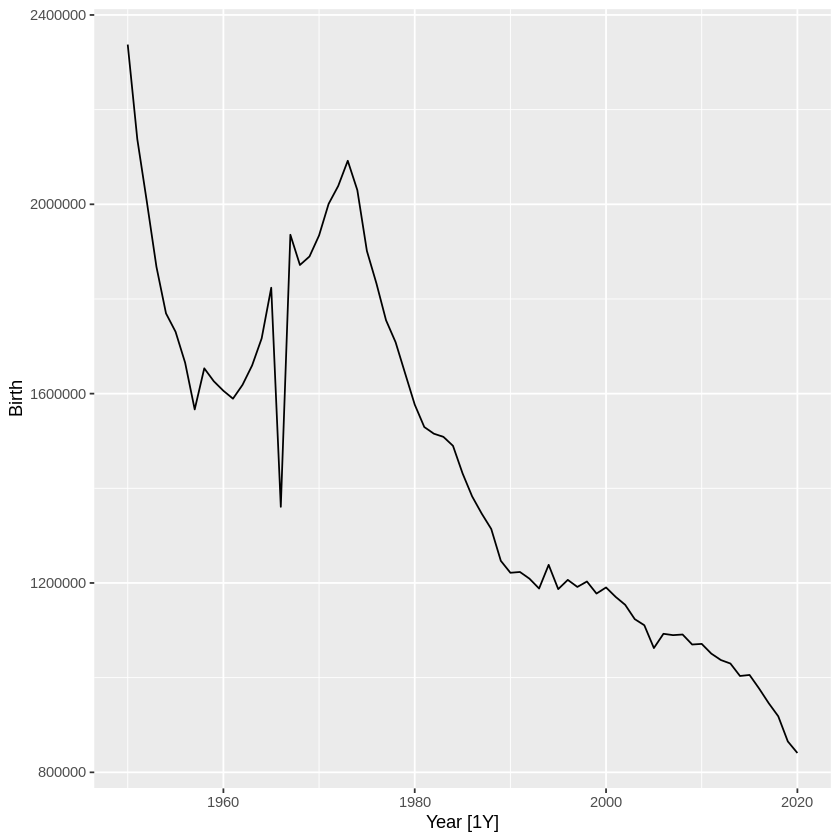

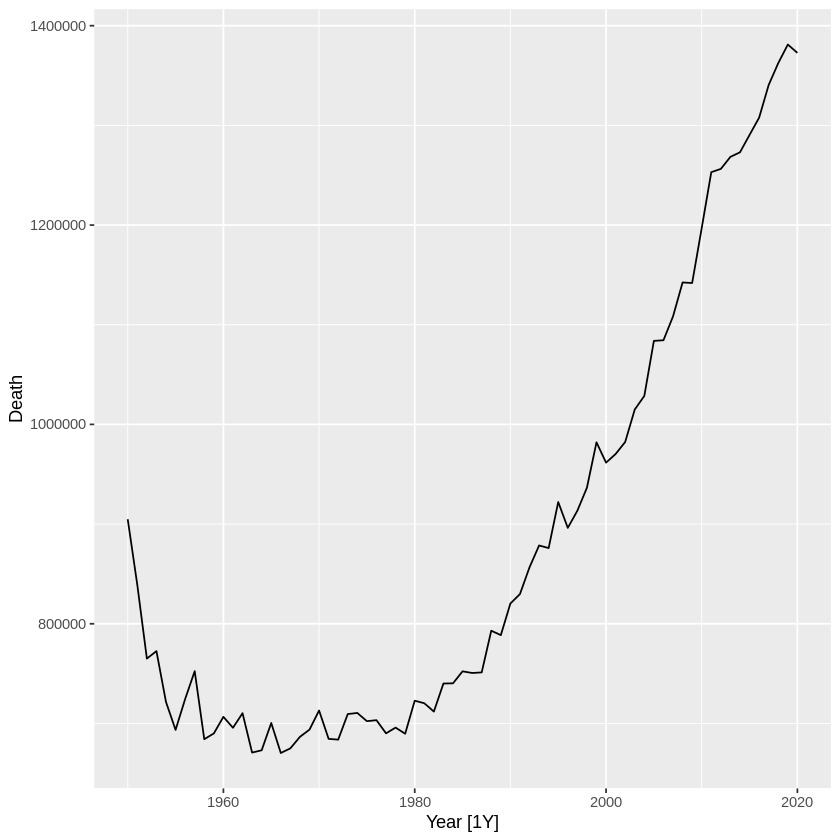

In [3]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡数のグラフ
pop_tsibble |>
  autoplot( Birth )
pop_tsibble |>
  autoplot( Death )

次に、自己相関を確認してみます。

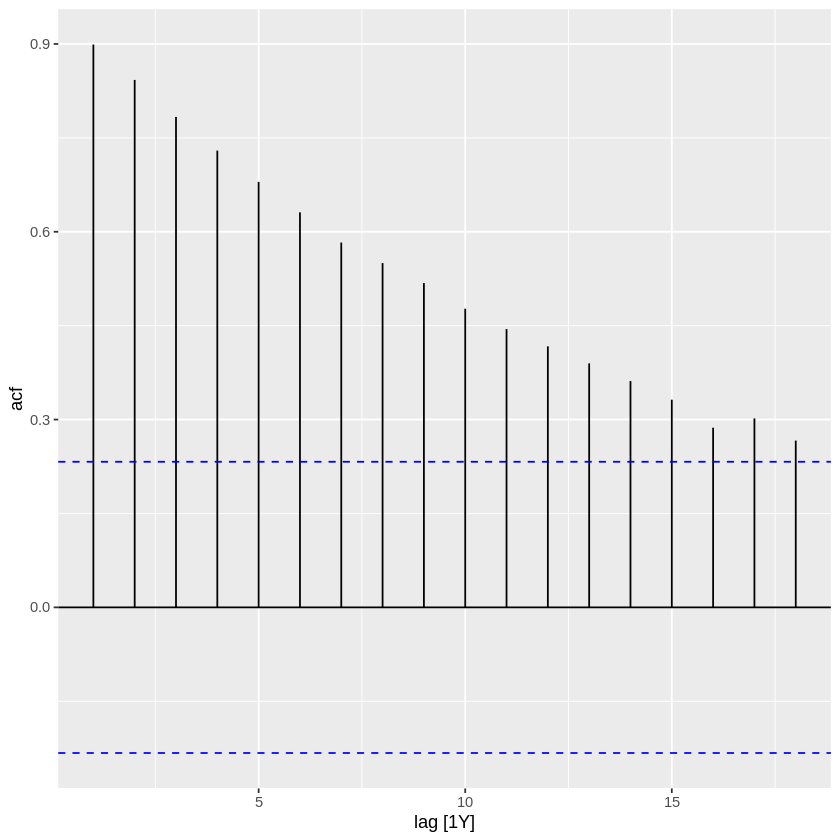

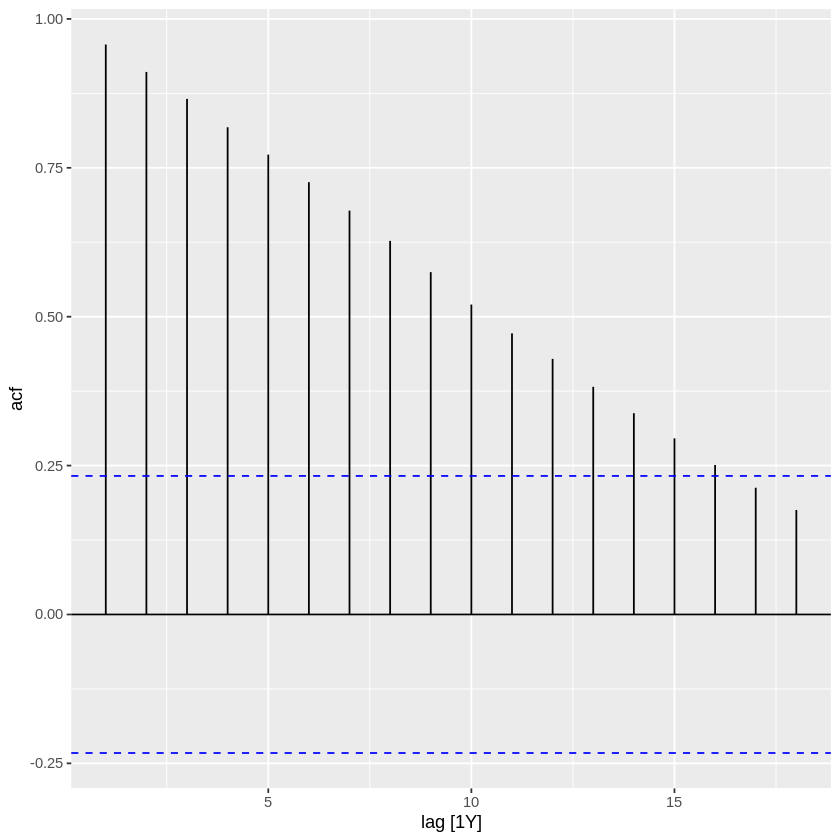

In [4]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble |>
  ACF( Death ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

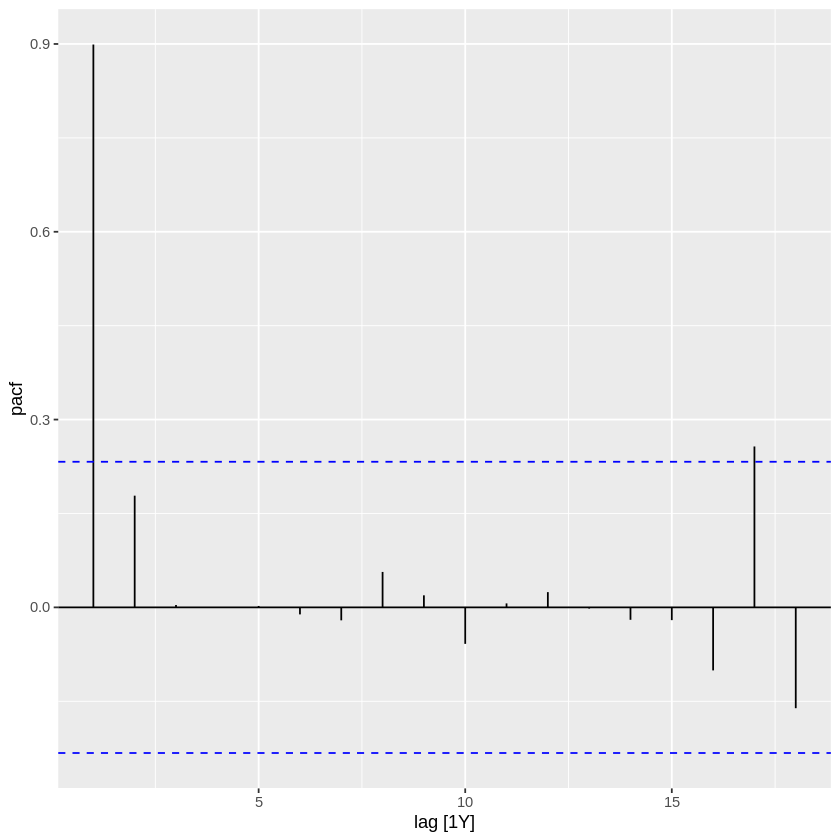

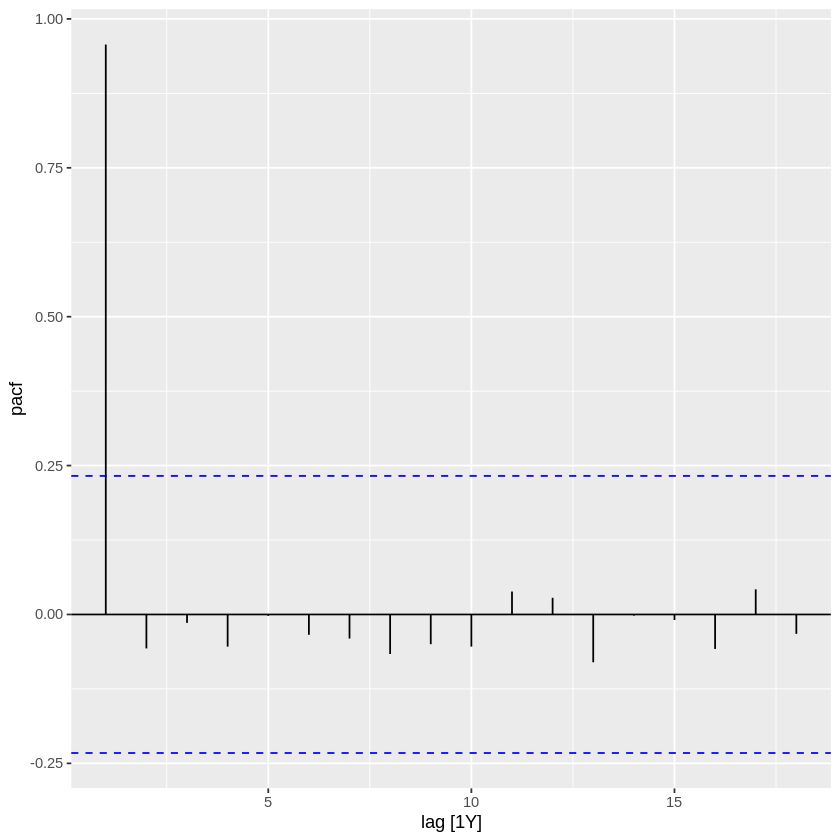

In [5]:
# 偏自己相関のグラフ
pop_tsibble |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble |>
  PACF( Death ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [6]:
# 予測データと訓練データ
6 -> prow_test2
pop_tsibble |> nrow() - prow_test2 -> prow_train2
pop_tsibble |> tail( n = prow_test2 ) -> pop_test2
pop_tsibble |> head( n = prow_train2 ) -> pop_train2

# 手順４　ＡＲＩＭＡモデルによる予測

まず、学習データを使ってＡＲＩＭＡモデルを推定します。

In [7]:
# ＡＲＩＭＡモデルの推定
pop_train2 |>
  model( arima = ARIMA( Birth, ic = "aic" )) -> pop_arimaB
pop_train2 |>
  model( arima = ARIMA( Death, ic = "aic" )) -> pop_arimaD
  pop_arimaB
  pop_arimaD

arima
<model>
"<ARIMA(1,1,0) w/ drift>"


arima
<model>
"<ARIMA(0,2,3)>"


出生では、ＡＲＩＭＡ（１，１，０）が  
死亡では、ＡＲＩＭＡ（０，２，３）が推定されたので、予測してみます。

In [8]:
# ＡＲＩＭＡによる予測
pop_arimaB |>
forecast( xreg = pop_test2$Birth,
          h = "6 years") -> pop_arimaB_f
pop_arimaD |>
  forecast( xreg = pop_test2$Death,
            h = "6 years") -> pop_arimaD_f
pop_arimaB_f
pop_arimaD_f

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
arima,2015,"N(985732, 1e+10)",985731.7
arima,2016,"N(964841, 1.4e+10)",964841.0
arima,2017,"N(945073, 2e+10)",945072.9
arima,2018,"N(924896, 2.6e+10)",924896.0
arima,2019,"N(9e+05, 3.1e+10)",904868.0
arima,2020,"N(884786, 3.7e+10)",884785.8


.model,Year,Death,.mean
<chr>,<dbl>,<dist>,<dbl>
arima,2015,"N(1308598, 6.2e+08)",1308598
arima,2016,"N(1335865, 1.1e+09)",1335865
arima,2017,"N(1355528, 1.6e+09)",1355528
arima,2018,"N(1375190, 2.5e+09)",1375190
arima,2019,"N(1394852, 3.7e+09)",1394852
arima,2020,"N(1414514, 5.4e+09)",1414514


# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [9]:
# ライブラリの読み込み
library( dplyr )

# 出生数、死亡数の合算
pop_test2 |> rename( "forecast_BD" = Total ) -> pop_arima_f2

pop_arimaB_f |>
  as.data.frame() |>
  select( .mean ) -> pop_arima_f2[ ,3 ]
pop_arimaD_f |>
  as.data.frame() |>
  select( .mean ) -> pop_arima_f2[ ,4 ]

pop_arima_f2 |>
  mutate( forecast_BD = lag( forecast_BD + Birth - Death )) -> pop_arima_f2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126772133,126838000,126864000,126912000,126938000
2017,126706000,126561976,126532000,126605000,126704000,126777000
2018,126443000,126295545,126177000,126315000,126441000,126580000
2019,126167000,125992706,125773000,125998000,126125000,126351000
2020,126146000,125677016,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`
Plot variable not specified, automatically selected `.vars = Death`


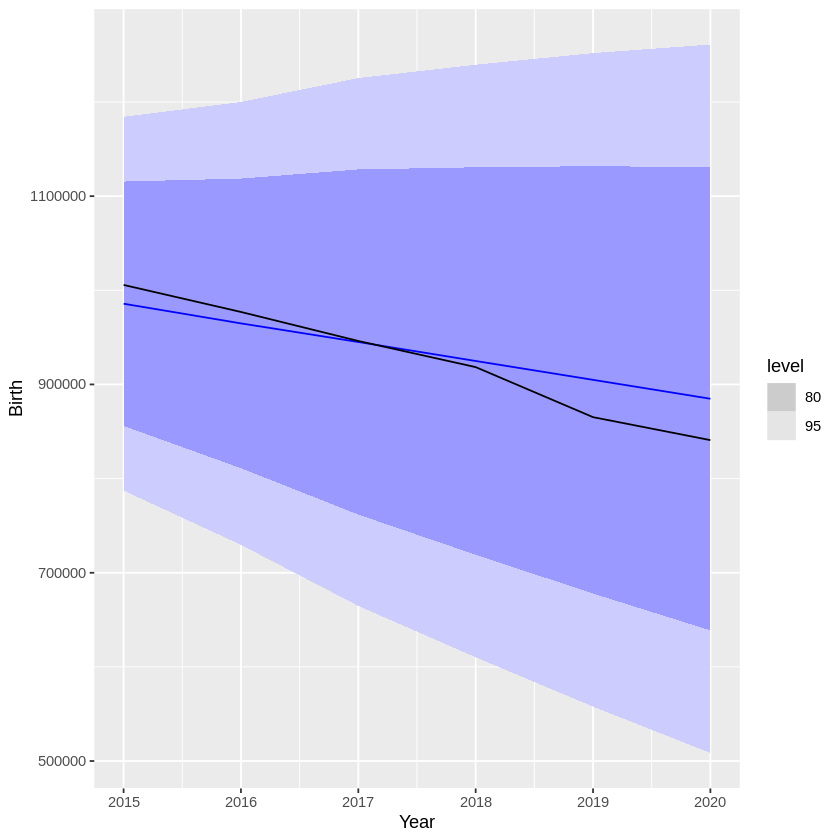

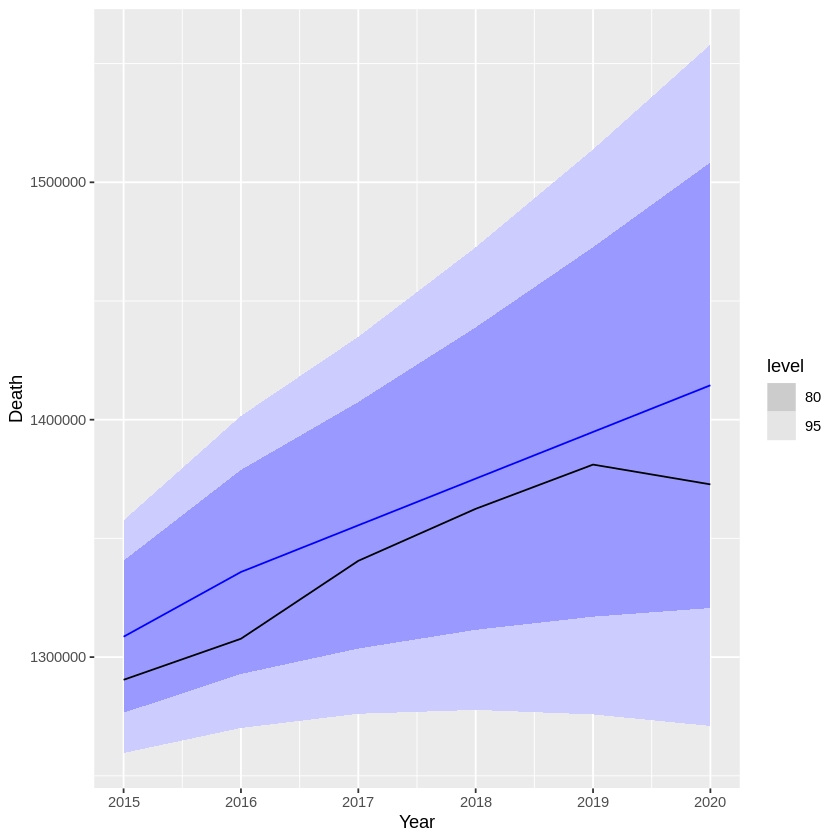

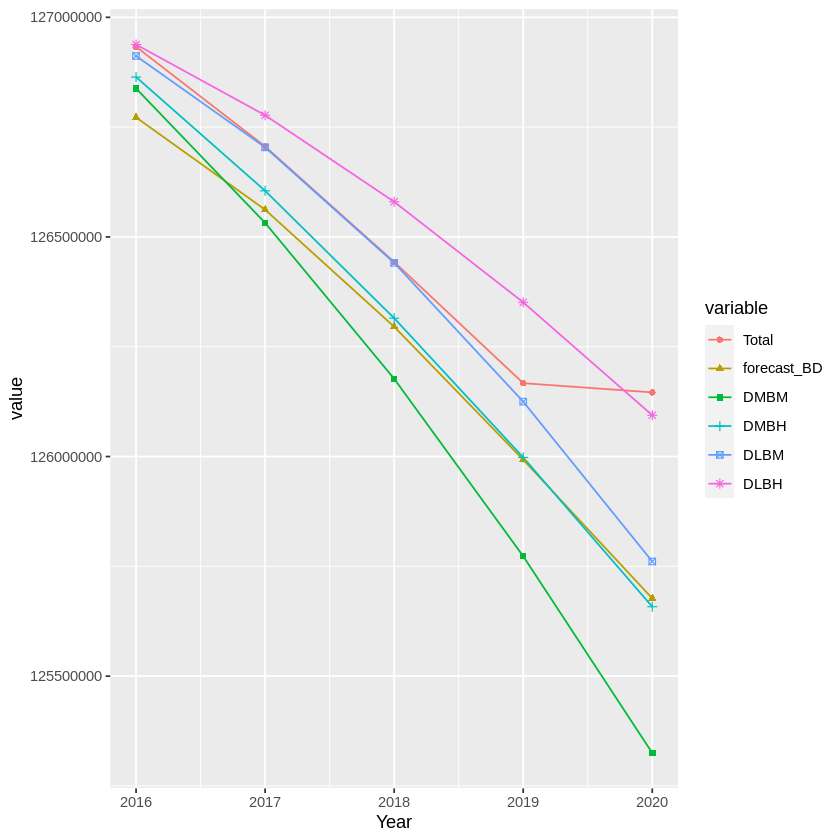

In [11]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# ネット上のファイル読み込み
ipssURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> ipss_test

# ＡＲＩＭＡモデル予測をはforecast_BD
# 実データがTotal
# 社人研の結果は、例えば死亡中位出生中位だとDMBM
  pop_arima_f2[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) -> join_test2

join_test2

# ライブラリの読み込み
library( reshape2 )

join_test2 |> 
  melt(id="Year",measure=c( "Total",
                            "forecast_BD",
                            "DMBM",
                            "DMBH",
                            "DLBM",
                            "DLBH")) -> join_plot2

#描画
pop_test2 |>
  select( Year, Birth ) -> pop_testB 
pop_arimaB_f |> autoplot() +
  autolayer( pop_testB )

pop_test2 |>
  select( Year, Death ) -> pop_testD
pop_arimaD_f |> autoplot() +
  autolayer( pop_testD )

ggplot( join_plot2,
        aes(x = Year,
            y = value,
            shape = variable,
            colour = variable,
            group = variable )) +
  geom_line() +
  geom_point()

今度は少し低めに出てしまいました。  
どうやら、死亡数を高めに見積もっている事が原因のようです。

# 次のステップ



*   同じ事をPythonでやってみる。　->　こちら
*   色んなモデルを当てはめてみる　->　こちら
*   死亡率を使って推計する　->　[Ｒ_人口推計_その３](https://colab.research.google.com/drive/1GZjPkMxsAQDvE9nLLD5ZN65lrpNtffMj?hl=ja)

